In [ ]:
########NODDI WATSON#########
# 1) Reads data and prepares model
# 2) Runs NODDI-Watson implementation
# 3) Inline visualization of outputs

In [2]:
from dipy.core.gradients import gradient_table
from dmipy.core.acquisition_scheme import gtab_dipy2dmipy
bvals0 = 'C://Users//310304075//Downloads//NODDI//sub-BMRI119477_dwi.bval'
bvecs0 = 'C://Users//310304075//Downloads//NODDI//sub-BMRI119477_dwi.bvec'
gt = gradient_table(bvals0, bvecs0)
acq_scheme_mipy = gtab_dipy2dmipy(gt)
acq_scheme_mipy.print_acquisition_info

Acquisition scheme summary

total number of measurements: 49
number of b0 measurements: 1
number of DWI shells: 2

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |1         |0               |N/A                      |N/A        |N/A       |N/A  
1           |16        |1000            |N/A                      |N/A        |N/A       |N/A  
2           |32        |2500            |N/A                      |N/A        |N/A       |N/A  


In [4]:
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.distributions.distribute_models import SD1WatsonDistributed
from dmipy.core.modeling_framework import MultiCompartmentModel
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()
watson_dispersed_bundle = SD1WatsonDistributed(models=[stick, zeppelin])
watson_dispersed_bundle.parameter_names
watson_dispersed_bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp','C1Stick_1_lambda_par','partial_volume_0')
watson_dispersed_bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
watson_dispersed_bundle.set_fixed_parameter('G2Zeppelin_1_lambda_par', 1.7e-9)
NODDI_mod = MultiCompartmentModel(models=[ball, watson_dispersed_bundle])
NODDI_mod.parameter_names
NODDI_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)

In [7]:
import nibabel as nib
import numpy as np
scheme_hcp = acq_scheme_mipy
data_hcp = nib.load('C://Users//310304075//Downloads//NODDI//eddy_corrected_dn_bfc_masked.nii//eddy_corrected_dn_bfc_masked.nii')
data_hcp=data_hcp.get_fdata()
data_hcp=data_hcp[:,:,30:35,:]
print(data_hcp.shape)

(144, 144, 5, 49)


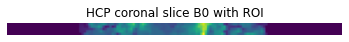

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 70, :, 30].T, origin='lower')
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

In [9]:
NODDI_fit_hcp = NODDI_mod.fit(
    scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)
np.save('C://Users//310304075//Downloads//fitparamPreproc.npy', NODDI_fit_hcp)

Using parallel processing with 4 workers.


C:\Users\310304075\Anaconda3\lib\site-packages\numba\core\ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mu' of function 'unitsphere2cart_1d'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "Anaconda3\lib\site-packages\dmipy\utils\utils.py", line 433:

def unitsphere2cart_1d(mu):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Setup brute2fine optimizer in 5.57309627532959 seconds
Fitting of 34928 voxels complete in 795.3980560302734 seconds.
Average of 0.02277250503980398 seconds per voxel.


(4,)
SD1WatsonDistributed_1_SD1Watson_1_mu
(144, 144, 5, 2)
0
SD1WatsonDistributed_1_SD1Watson_1_odi
(144, 144, 5)
SD1WatsonDistributed_1_SD1Watson_1_odi
(144, 144, 5)
1
SD1WatsonDistributed_1_partial_volume_0
(144, 144, 5)
SD1WatsonDistributed_1_partial_volume_0
(144, 144, 5)
2
partial_volume_0
(144, 144, 5)
partial_volume_0
(144, 144, 5)
3
partial_volume_1
(144, 144, 5)
partial_volume_1
(144, 144, 5)
4


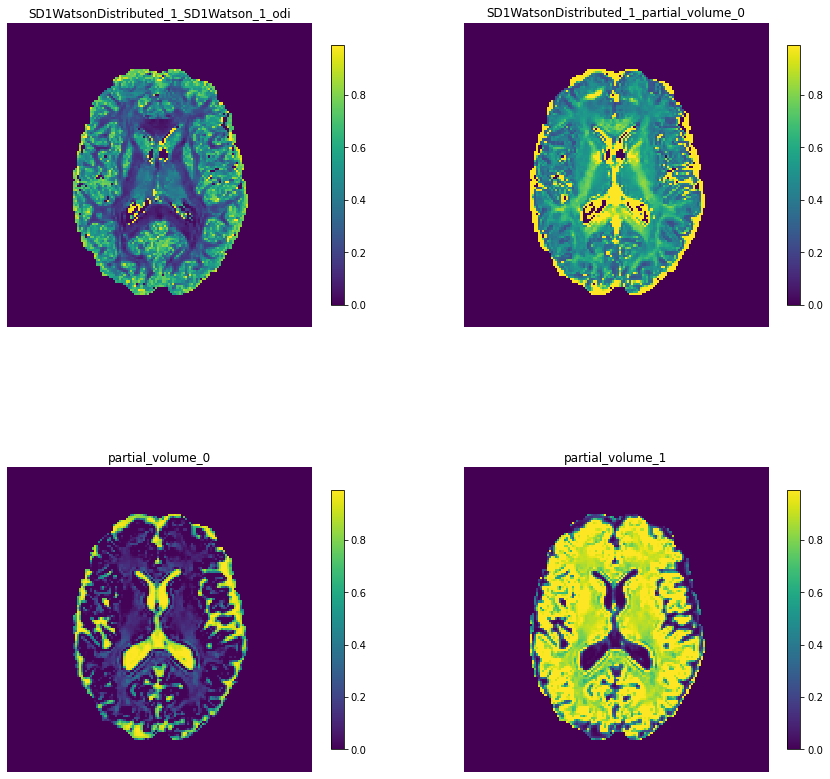

In [11]:
NODDI_fit_hcp = np.load('C://Users//310304075//Downloads//fitparamPreproc.npy',allow_pickle='TRUE').item()
fitted_parameters = NODDI_fit_hcp.fitted_parameters
fig, axs = plt.subplots(2, 2, figsize=[15, 15])
axs = axs.ravel()
print (axs.shape)
counter = 0
for name, values in fitted_parameters.items():
    print (name)
    print (values.shape)
    #if values.squeeze().ndim != 2:
    if counter != 0:
        print (name)
        print (values.shape)
        cf = axs[counter-1].imshow(values[:,:,3].T, origin='lower', interpolation='nearest')
        axs[counter-1].set_axis_off()
        axs[counter-1].set_title(name)
        fig.colorbar(cf, ax=axs[counter-1], shrink=0.7)
    print (counter)
    counter += 1

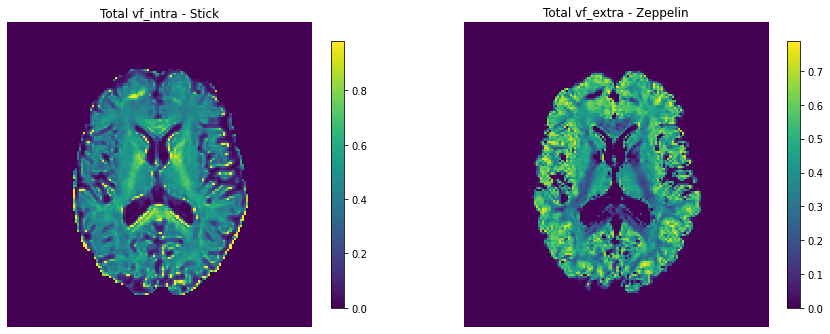

In [12]:
# get total Stick signal contribution
vf_intra = (fitted_parameters['SD1WatsonDistributed_1_partial_volume_0'] *
            fitted_parameters['partial_volume_1'])
# get total Zeppelin signal contribution
vf_extra = ((1 - fitted_parameters['SD1WatsonDistributed_1_partial_volume_0']) *
            fitted_parameters['partial_volume_1'])
fig, axs = plt.subplots(1, 2, figsize=[15, 7])
axs = axs.ravel()

counter = 0
for name, values in zip(['Total vf_intra - Stick', 'Total vf_extra - Zeppelin'], [vf_intra, vf_extra]):
    cf = axs[counter].imshow(values[:,:,3].T, origin='lower', interpolation='nearest')
    axs[counter].set_axis_off()
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.7)
    counter += 1

C:\Users\310304075\Anaconda3\lib\site-packages\dmipy\core\fitted_modeling_framework.py:263: RuntimeWarning: divide by zero encountered in true_divide
  data_ = data / self.S0[..., None]
C:\Users\310304075\Anaconda3\lib\site-packages\dmipy\core\fitted_modeling_framework.py:263: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]
C:\Users\310304075\Anaconda3\lib\site-packages\dmipy\core\fitted_modeling_framework.py:250: RuntimeWarning: divide by zero encountered in true_divide
  data_ = data / self.S0[..., None]
C:\Users\310304075\Anaconda3\lib\site-packages\dmipy\core\fitted_modeling_framework.py:250: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]


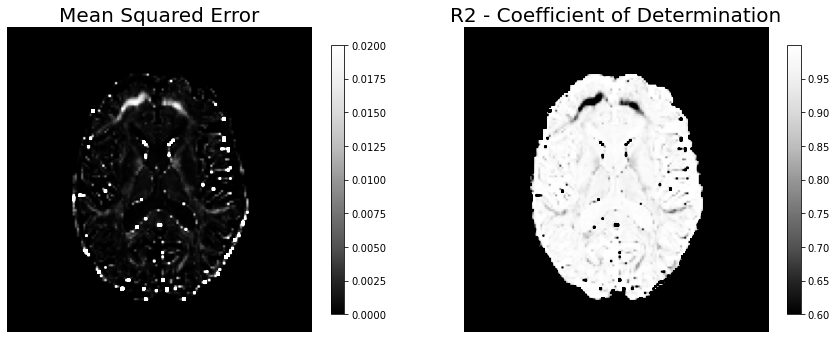

In [13]:
mse = NODDI_fit_hcp.mean_squared_error(data_hcp)
R2 = NODDI_fit_hcp.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse[:,:,3].T, origin='lower', vmax=0.02, cmap='Greys_r')
axs[0].set_axis_off()
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2[:,:,3].T, origin='lower', vmin=0.6, cmap='Greys_r')
axs[1].set_axis_off()
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);